In [1]:
import os
import pathlib
import keras
import numpy as np
import tensorflow as tf

In [2]:
root_dir = pathlib.Path('../data/Aksara-Sunda')

In [3]:
def CreateDataset(data_dir, type=None):
    data_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        label_mode='categorical',
        color_mode='rgb',
        batch_size=32,
        image_size=(150, 150),
        seed=123,
        validation_split=0.2,
        subset=type
    )
    
    return data_ds

train_ds = CreateDataset(root_dir, 'training')
valid_ds = CreateDataset(root_dir, 'validation')

Found 23970 files belonging to 43 classes.
Using 19176 files for training.
Found 23970 files belonging to 43 classes.
Using 4794 files for validation.


In [4]:
class_names = train_ds.class_names
print('Class Names:\n {}'.format(class_names))

Class Names:
 ['a', 'ba', 'ca', 'da', 'e', 'ee', 'eu', 'fa', 'ga', 'ha', 'i', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'ou', 'pa', 'qa', 'ra', 'sa', 'ta', 'u', 'va', 'vowels_e', 'vowels_ee', 'vowels_eu', 'vowels_h', 'vowels_i', 'vowels_la', 'vowels_ng', 'vowels_o', 'vowels_r', 'vowels_ra', 'vowels_u', 'vowels_x', 'vowels_ya', 'wa', 'xa', 'ya', 'za']


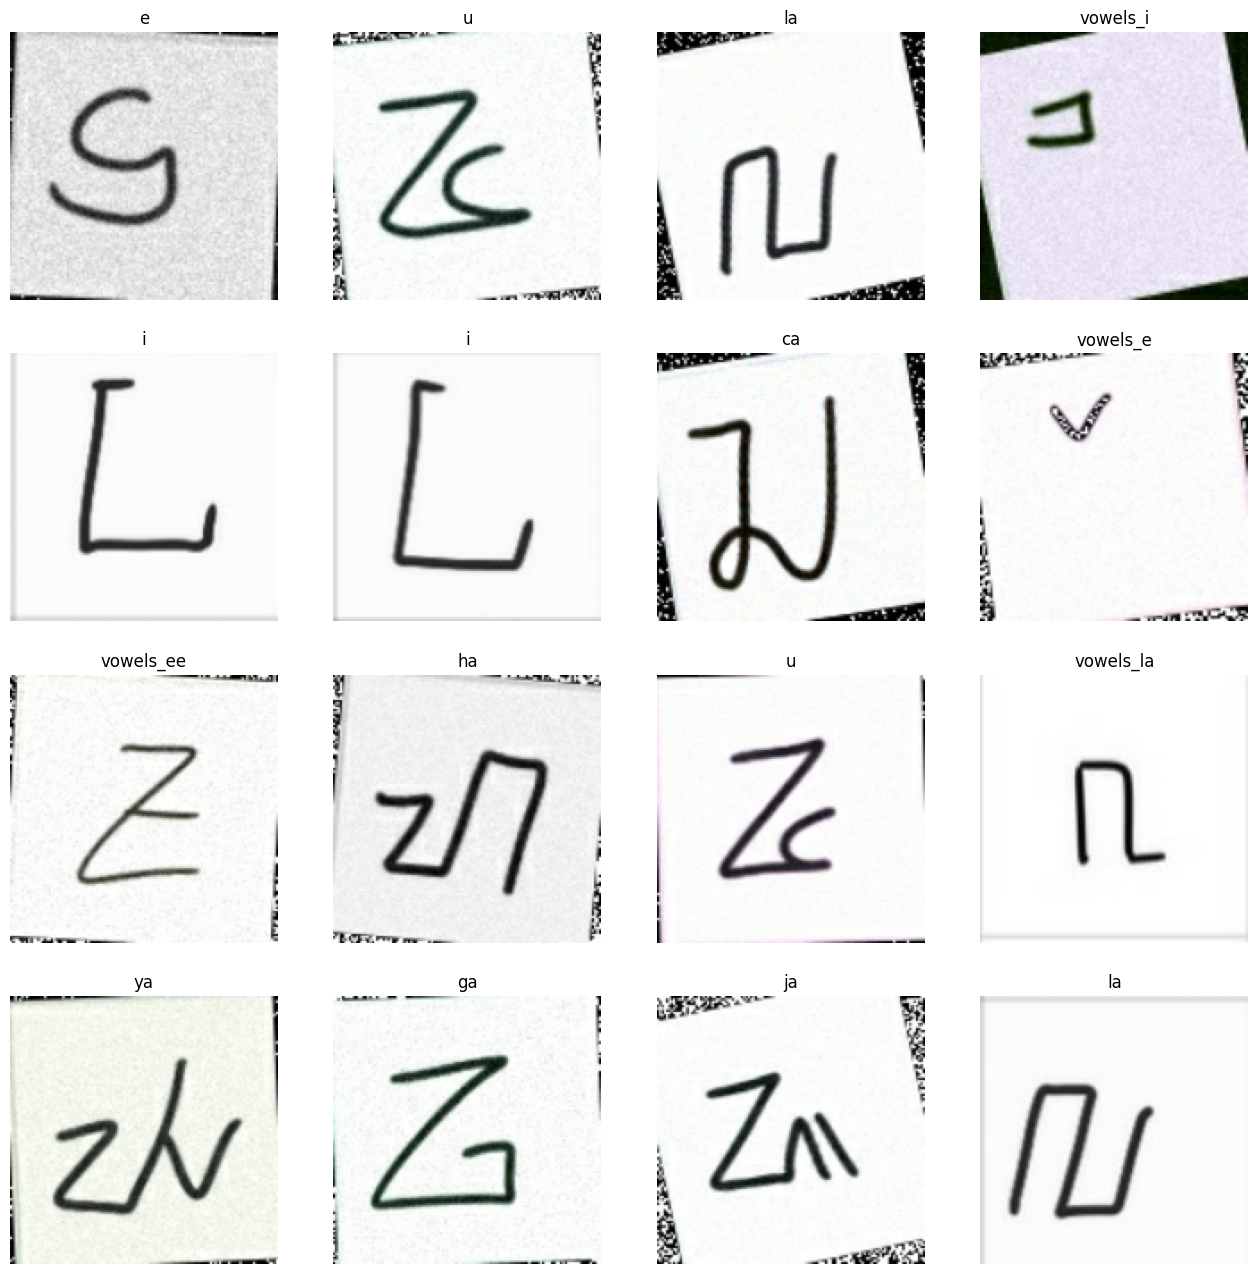

In [5]:
import matplotlib.pyplot as plt

def PlotDataset(dataset, class_list):
    plt.figure(figsize=(16, 16))
    for images, labels in dataset.take(1):
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            class_index = np.argmax(labels[i])
            plt.title(class_list[class_index])
            plt.axis('off')

PlotDataset(train_ds, class_names)

In [6]:
for image_batch, labels_batch in train_ds:
  print('Batch Image Shape:', image_batch.shape)
  print('Batch Labels Shape:', labels_batch.shape)
  break

Batch Image Shape: (32, 150, 150, 3)
Batch Labels Shape: (32, 43)


In [ ]:
RESCALE = tf.keras.models.Sequential([keras.layers.Rescaling(1./255.)])

train_ds = train_ds.map(lambda x, y: (RESCALE(x), y))
valid_ds = valid_ds.map(lambda x, y: (RESCALE(x), y))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))

model = tf.keras.models.Sequential([
    inputs, 
    # tf.keras.layers.Rescaling(1./255.),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(860, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(430, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(43, activation='softmax', name='classification_layers')
])

model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy')>0.995 and logs.get('accuracy')>0.995:
      print("\nReached 99% accuracy!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5), callbacks]
)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [9]:
def save_my_model(model, history, type=None):
    accuracy = history.history['accuracy'][-1] * 1000
    val_accuracy = history.history['val_accuracy'][-1] * 1000
    
    model.save(f'../models/model_sunda_{type}_{int(accuracy)}_{int(val_accuracy)}.h5')

In [ ]:
save_my_model(model, history, type='conv')

# Using Transfer Learning

In [13]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(150, 150, 3))

model = tf.keras.models.Sequential([
    inputs,
    base_model,
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(860, activation='relu'),
    tf.keras.layers.Dense(645, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(43, activation='softmax')
], name='Sundanese_script')

model.summary()

Model: "Sundanese_script"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 5, 5, 1280)        5919312   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_2 (Dense)             (None, 645)               20640645  
                                                                 
 dropout_1 (Dropout)         (None, 645)               0         
                                                                 
 dense_3 (Dense)             (None, 43)                27778     
                                                                 
Total params: 26587735 (101.42 MB)
Trainable params: 20668423 (78.84 MB)
Non-trainable params: 5919312 (22.58 MB)
__

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    verbose=1,
    callbacks=callbacks
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5), callbacks]
)

Epoch 1/50
600/600 [==============================] - 264s 425ms/step - loss: 0.5368 - accuracy: 0.8568 - val_loss: 0.0662 - val_accuracy: 0.9783
Epoch 2/50
600/600 [==============================] - 233s 388ms/step - loss: 0.1125 - accuracy: 0.9616 - val_loss: 0.0581 - val_accuracy: 0.9829
Epoch 3/50
600/600 [==============================] - 230s 383ms/step - loss: 0.0843 - accuracy: 0.9722 - val_loss: 0.0578 - val_accuracy: 0.9827
Epoch 4/50
600/600 [==============================] - 236s 393ms/step - loss: 0.0813 - accuracy: 0.9730 - val_loss: 0.0407 - val_accuracy: 0.9844
Epoch 5/50
600/600 [==============================] - 238s 397ms/step - loss: 0.0715 - accuracy: 0.9783 - val_loss: 0.0453 - val_accuracy: 0.9852
Epoch 6/50
600/600 [==============================] - 235s 392ms/step - loss: 0.0643 - accuracy: 0.9798 - val_loss: 0.0264 - val_accuracy: 0.9898
Epoch 7/50
600/600 [==============================] - 244s 406ms/step - loss: 0.0681 - accuracy: 0.9808 - val_loss: 0.0220 -

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
save_my_model(model, history, type='efficientnet_v2')